In [1]:
from plotnine import *
import pandas as pd
import numpy as np

In [20]:
# time = "2024-03-29_04:53"
time = "2024-03-29_07:23"
time = "2024-03-31_15:54"
time = "2024-03-31_16:37"
time = "2024-03-31_17:12"
time = "2024-04-01_15:42"
time = "2024-04-01_17:06"
time = "2024-04-01_18:11"
time = "2024-04-16_16:47"
time = "2024-04-18_19:23"
time = "2024-04-18_20:30"
time = "2024-04-19_01:29"
time = "2024-04-19_09:39"
time = "2024-05-19_16:34"
time = "2024-05-19_16:58"
time = "2024-05-19_17:38"
time = "2024-05-19_18:55"
time = "2024-05-20_04:15"
time = "2024-05-20_10:30"


df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")

# df['test_cumsum_annualized_return'] = df['test_cumsum_annualized_return'] * -1
# remove where dist_measure is 2
# remove where future_candles is 5
# remove where n_clusters is 150 or 200
# remove where log_return_threshold is greater than 0.01
# remove where calmar_ratio_threshold is not 2

# df = df[df["dist_measure"] != 2]
# df = df[df["window"] < 5]
# df = df[df["random_state"] == 42]
# df = df[df["test_size"] == 2880]
# df = df[df["algorithm"] == "kmeans"]
# df = df[(df["test_negative_sharpe_ratio"] >= 1) | (df["test_sharpe_ratio"] >= 1)]
df = df[(df["test_negative_sharpe_ratio"] >= 0.15) | (df["test_sharpe_ratio"] >= 0.15)]

df = df[(df["algorithm"] == 'gaussian_mixture')]
df = df[(df["max_k_labels"] == 1)]
df = df[(df["random_state"] == 200)]

df

,window,train_sum_annualized_return,train_sum_actual_return,train_n_trades,test_sum_annualized_return,test_sum_actual_return,test_n_trades,train_cumsum_annualized_return,train_cumsum_actual_return,train_sharpe_ratio,test_cumsum_annualized_return,test_cumsum_actual_return,test_sharpe_ratio,test_negative_sharpe_ratio,max_k_labels,n_clusters,algorithm,train_size,test_size,random_state
204683,0,0.30,30,81,0.00,0,6,0.30,30,3.006919,0.00,0,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200
204684,1,0.26,26,40,0.07,7,11,0.56,56,3.006919,0.07,7,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200
204685,2,0.40,40,67,-0.20,-20,24,0.96,96,3.006919,-0.13,-13,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200
204686,3,0.21,21,51,0.02,2,22,1.17,117,3.006919,-0.11,-11,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200
204687,4,0.29,29,65,0.16,16,24,1.46,146,3.006919,0.05,5,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204808,125,0.26,26,34,0.05,5,7,42.40,4240,3.006919,-3.22,-322,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200
204809,126,0.47,47,109,-0.19,-19,27,42.87,4287,3.006919,-3.41,-341,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200
204810,127,0.38,38,74,-0.35,-35,62,43.25,4325,3.006919,-3.76,-376,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200
204811,128,0.31,31,61,0.02,2,5,43.56,4356,3.006919,-3.74,-374,-0.337268,0.165327,1,100,gaussian_mixture,2880,960,200


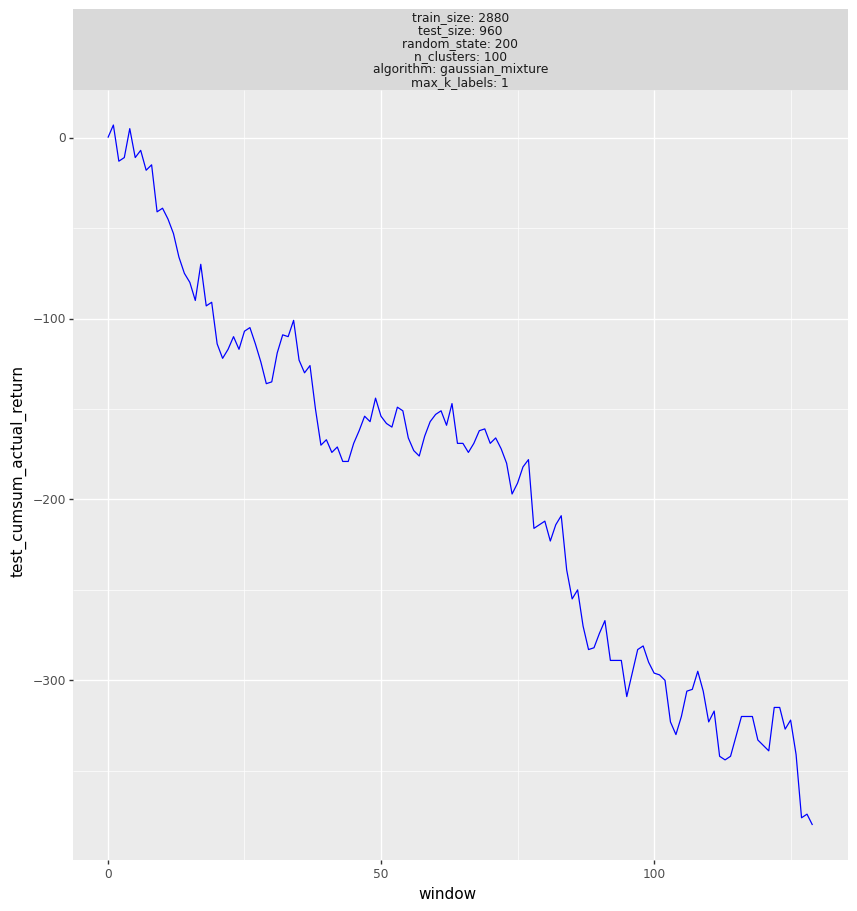

In [21]:
p = ggplot(df)
# p = p + geom_line(aes(x="window", y="train_cumsum_annualized_return"), color="red")
p = p + geom_line(aes(x="window", y="test_cumsum_actual_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_avg_calmar_ratio"), color="red")
# p = p + facet_wrap("~train_size + random_state", scales="free_x", labeller="label_both")
p = p + facet_wrap("~train_size + test_size + random_state + n_clusters + algorithm + max_k_labels", scales="free_x", labeller="label_both")
# p = p + theme(figure_size=(35, 35))
p = p + theme(figure_size=(10, 10))
print(p)

In [ ]:

time = "2024-03-14_19:00"
df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/kmeans/results/{time}_results.csv")

p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumsum_annualized_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_cumsum_annualized_return"), color="red")
p = p + facet_wrap("~train_size + test_size + random_state", scales="free_x", labeller="label_both")
p = p + theme(axis_text_x=element_text(angle=90), figure_size=(30, 30))
print(p)